In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-translate-dataframe-english-to-uzbek/emotion_dataset_uzbek_test.csv
/kaggle/input/google-translate-dataframe-english-to-uzbek/__results__.html
/kaggle/input/google-translate-dataframe-english-to-uzbek/emotion_dataset_uzbek_validation.csv
/kaggle/input/google-translate-dataframe-english-to-uzbek/__notebook__.ipynb
/kaggle/input/google-translate-dataframe-english-to-uzbek/__output__.json
/kaggle/input/google-translate-dataframe-english-to-uzbek/emotion_dataset_uzbek_train.csv
/kaggle/input/google-translate-dataframe-english-to-uzbek/custom.css


In [2]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV files
train_df = pd.read_csv('/kaggle/input/google-translate-dataframe-english-to-uzbek/emotion_dataset_uzbek_train.csv')
val_df = pd.read_csv('/kaggle/input/google-translate-dataframe-english-to-uzbek/emotion_dataset_uzbek_validation.csv')

# Load the Uzbek RoBERTa tokenizer and model
model_name = 'rifkat/uztext-3Gb-BPE-Roberta'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

# Tokenize the dataset
def tokenize_function(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=128)

train_encodings = tokenize_function(train_df['uzbek_text'].tolist())
val_encodings = tokenize_function(val_df['uzbek_text'].tolist())

# Create PyTorch datasets
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(train_encodings, train_df['label'].tolist())
val_dataset = EmotionDataset(val_encodings, val_df['label'].tolist())

2024-06-28 06:43:43.270385: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 06:43:43.270532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 06:43:43.453090: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/964k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/334M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at rifkat/uztext-3Gb-BPE-Roberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
train_dataset

In [4]:
# Define the metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted"),
        "precision": precision_score(labels, predictions, average="weighted"),
        "recall": recall_score(labels, predictions, average="weighted")
    }

# Set up the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    #learning_rate=2e-3, # was off
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.974800,0.755092,0.748500,0.740654,0.755353,0.748500
2,0.548300,0.681561,0.751500,0.755102,0.764017,0.751500
3,0.237000,0.712488,0.784000,0.783026,0.782995,0.784000


TrainOutput(global_step=3000, training_loss=0.6291754774649938, metrics={'train_runtime': 15221.7251, 'train_samples_per_second': 3.153, 'train_steps_per_second': 0.197, 'total_flos': 1589722177536000.0, 'train_loss': 0.6291754774649938, 'epoch': 3.0})

In [5]:
# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Save the fine-tuned model
model.save_pretrained("./emotion_classifier_model")
tokenizer.save_pretrained("./emotion_classifier_tokenizer")

Evaluation results: {'eval_loss': 0.6815605759620667, 'eval_accuracy': 0.7515, 'eval_f1': 0.7551018896337804, 'eval_precision': 0.7640173258302095, 'eval_recall': 0.7515, 'eval_runtime': 176.9048, 'eval_samples_per_second': 11.306, 'eval_steps_per_second': 0.181, 'epoch': 3.0}


('./emotion_classifier_tokenizer/tokenizer_config.json',
 './emotion_classifier_tokenizer/special_tokens_map.json',
 './emotion_classifier_tokenizer/vocab.json',
 './emotion_classifier_tokenizer/merges.txt',
 './emotion_classifier_tokenizer/added_tokens.json',
 './emotion_classifier_tokenizer/tokenizer.json')

Text: 'Men bugun juda xursandman!'
Predicted emotion: joy
Validation Accuracy: 0.7515
Validation F1 Score: 0.7551
Validation Precision: 0.7640
Validation Recall: 0.7515


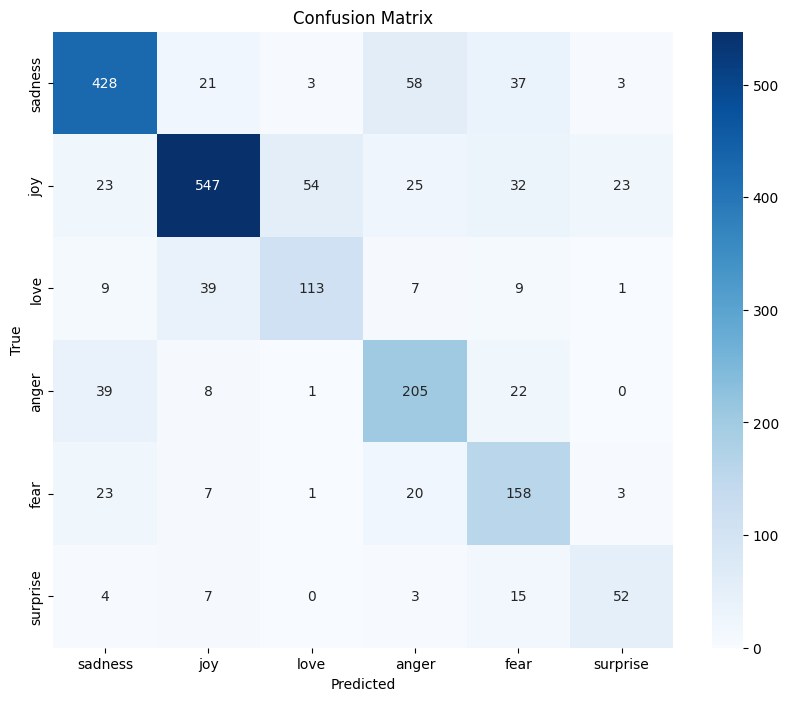

              precision    recall  f1-score   support

     sadness       0.81      0.78      0.80       550
         joy       0.87      0.78      0.82       704
        love       0.66      0.63      0.65       178
       anger       0.64      0.75      0.69       275
        fear       0.58      0.75      0.65       212
    surprise       0.63      0.64      0.64        81

    accuracy                           0.75      2000
   macro avg       0.70      0.72      0.71      2000
weighted avg       0.76      0.75      0.76      2000



In [6]:
def predict_emotion(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()
    emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    return emotion_labels[predicted_class]

# Example usage
test_text = "Men bugun juda xursandman!"  # "I'm very happy today!" in Uzbek
predicted_emotion = predict_emotion(test_text)
print(f"Text: '{test_text}'")
print(f"Predicted emotion: {predicted_emotion}")

# Comprehensive evaluation on the validation set
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
labels = val_df['label'].tolist()

# Calculate metrics
accuracy = accuracy_score(labels, preds)
f1 = f1_score(labels, preds, average="weighted")
precision = precision_score(labels, preds, average="weighted")
recall = recall_score(labels, preds, average="weighted")

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")

# Calculate and plot confusion matrix
cm = confusion_matrix(labels, preds)
emotion_labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(labels, preds, target_names=emotion_labels))